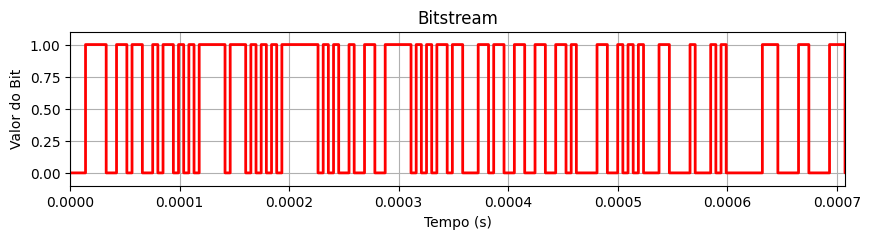

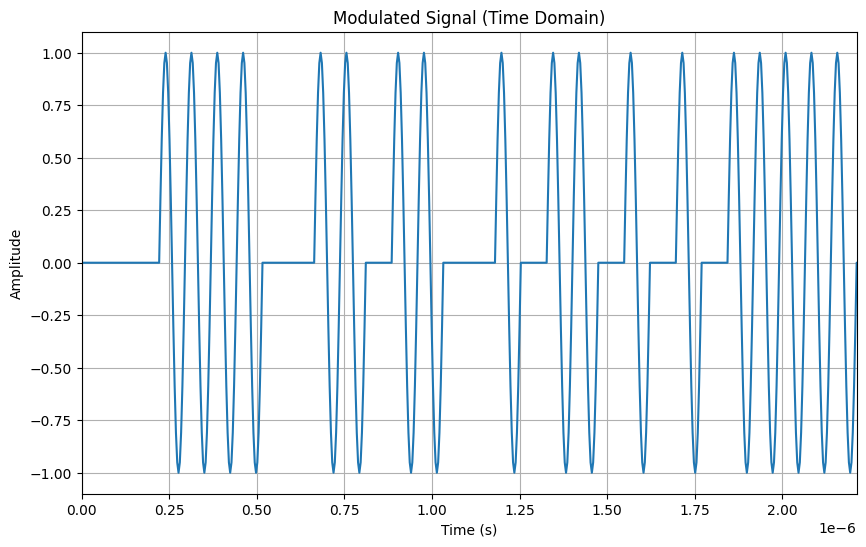

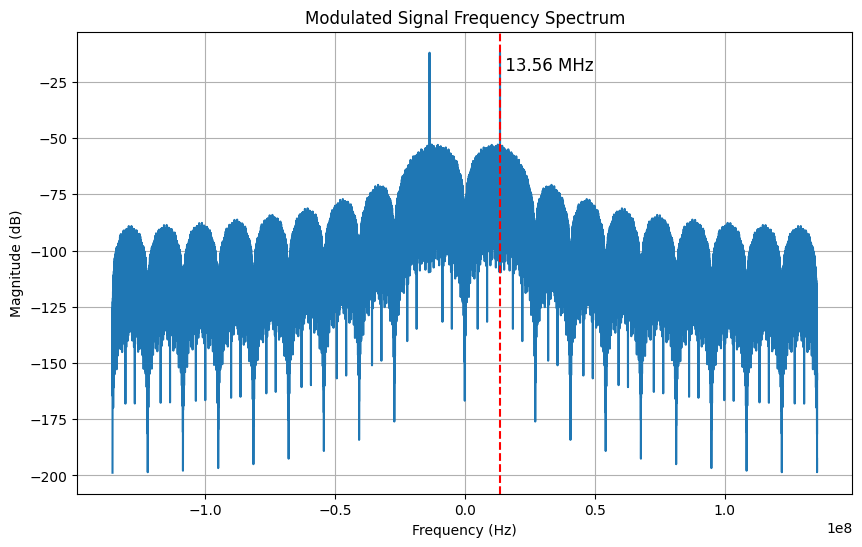

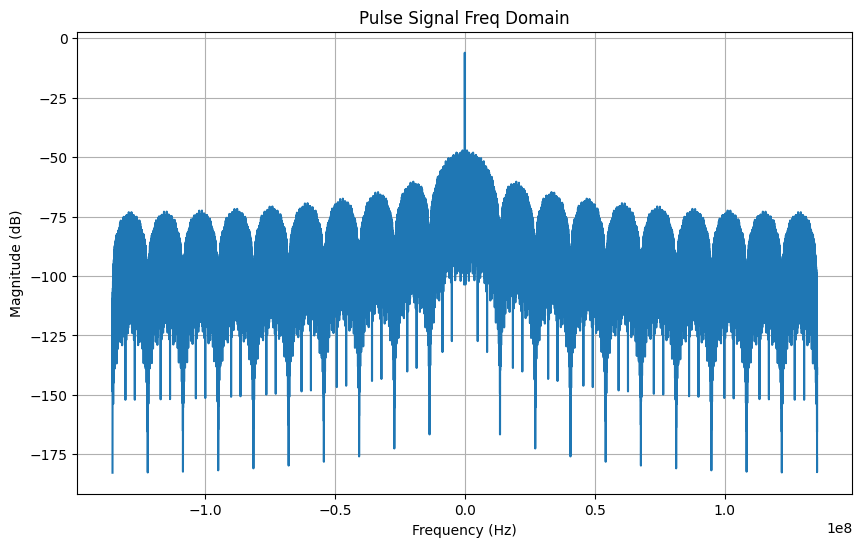

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
overSamplingValue = 20
Fc = 13.56e6  # Carrier Freq (13.56 MHz)
Fs = overSamplingValue*Fc  # Sampling Rate 
duration = 0.05  # Signal duration in seconds
bits_per_second = 424e3  # Bit transmission rate (424 kbps)

# Generate Random Bitstream
num_bits = int(duration * bits_per_second)
bitstream = np.random.randint(0, 2, num_bits)

# Generate pulse sequence
rect_pulses = np.repeat(bitstream,overSamplingValue)

# Create Carrier Signal 
t = np.arange(0, duration, 1/Fs)
t = t[:np.size(rect_pulses)]
carrier = np.sin(2 * np.pi * Fc * t)

samples_per_bit = int(Fs/bits_per_second)

# OOK Modulation 
modulated_signal = carrier.copy()

modulated_signal = modulated_signal * rect_pulses

# Plot Pulse Signal in Time Domain
plt.figure(figsize=(10, 2))
plt.step(np.arange(0,overSamplingValue*duration,1/bits_per_second), rect_pulses, where='post', color='red', linewidth=2)
plt.title('Bitstream')
plt.xlabel('Tempo (s)')
plt.ylabel('Valor do Bit')
plt.ylim(-0.1, 1.1)
plt.xlim(0,3000*(1/bits_per_second))
plt.grid(True)
plt.show()

# Plot Modulated signal in Time Domain
plt.figure(figsize=(10, 6))
plt.plot(t, modulated_signal)
plt.title('Modulated Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, (1/Fs)*600)
plt.grid(True)
plt.show()

# Plot Modulated Signal in Freq Domain
plt.figure(figsize=(10, 6))
plt.magnitude_spectrum(modulated_signal, Fs=Fs, scale='dB',sides='twosided')
plt.title('Modulated Signal Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
#plt.xlim(0.5*Fc, 1.5*Fc)  # Plot Automatically shows interested frequencies
plt.axvline(x=Fc, color='red', linestyle='--')
plt.text(x=Fc,y=-20,s=' 13.56 MHz ',fontsize='large',ha='left')
plt.show()

# Plot Pulse Signal in Freq Domain
plt.figure(figsize=(10, 6))
plt.magnitude_spectrum(rect_pulses,Fs=Fs,scale='dB',sides='twosided')
plt.title('Pulse Signal Freq Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

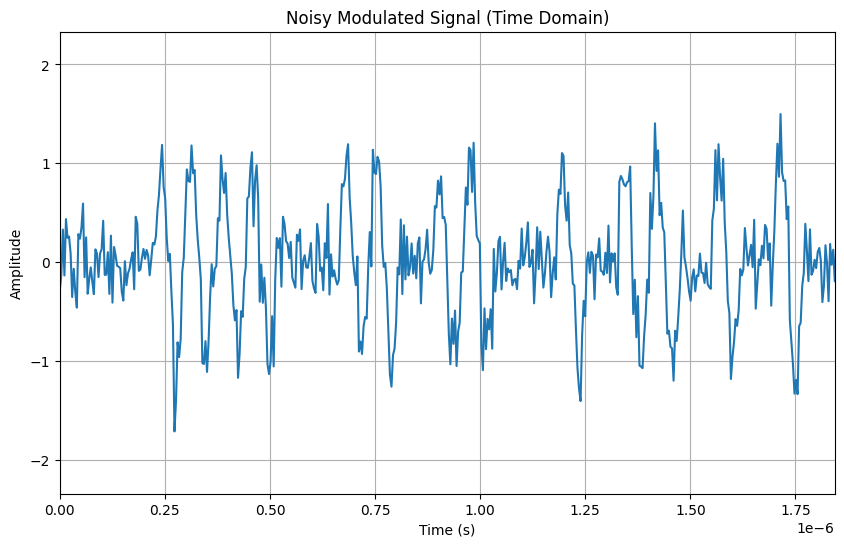

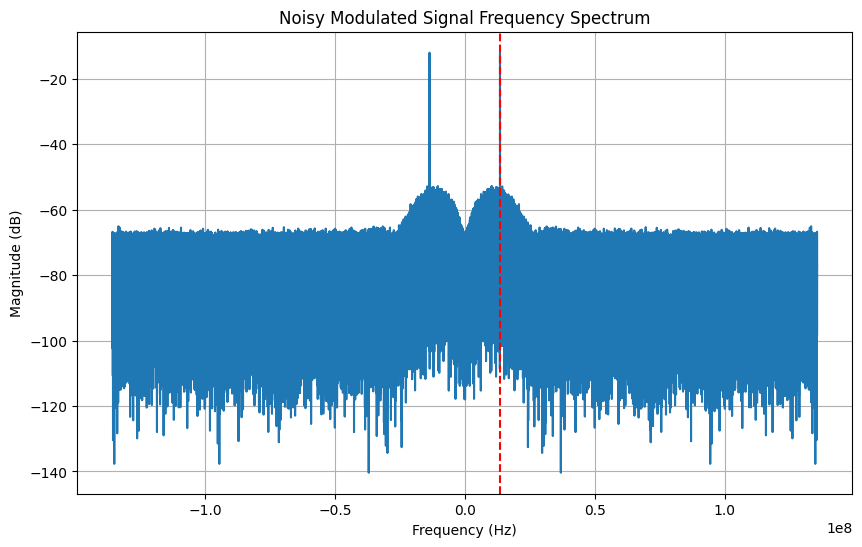

In [11]:
SNR_dB = 6 # Signal to Noise ratio in dB

# Add AWGN on modulated signal
# Calculate modulated signal power
signal_power = np.mean(modulated_signal ** 2)

# Calculate the noise power using the desired SNR
noise_power = signal_power / (10 ** (SNR_dB / 10))

# Generate noise signal with same size as modulated signal and corresponding noise power. 
noise = np.random.normal(scale=np.sqrt(noise_power), size=len(modulated_signal))

# Adding the noise to the modulated signal
noisy_modulated_signal = modulated_signal + noise

# Time Domain Plot of the noisy modulated signal
plt.figure(figsize=(10, 6))
plt.plot(t, noisy_modulated_signal)
plt.title('Noisy Modulated Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, (1/Fs)*500)
plt.grid(True)
plt.show()

# Freq Domain Plot of the noisy modulated signal
plt.figure(figsize=(10, 6))
plt.magnitude_spectrum(noisy_modulated_signal, Fs=Fs, scale='dB',sides='twosided')
plt.title('Noisy Modulated Signal Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
#plt.xlim(0, 1.5*Fc) 
plt.axvline(x=Fc, color='red', linestyle='--')
plt.show()


In [3]:
# Demodulation OOK (Envelope Detection)
envelope = np.abs(noisy_modulated_signal)

# Define a Threshold related to decide between 0s and 1s.
threshold = 0.5
# Adequate value for a signal that lives between [0,1]

# Bitstream Decode
decoded_bitstream = np.zeros_like(bitstream)
for i in range(np.size(bitstream)):
    start = i * overSamplingValue 
    end = (i+1) * overSamplingValue
    eval_index = int((0.7 * end) + (0.3 * start))
    if envelope[eval_index] > threshold:
        decoded_bitstream[i] = 1
        
# Determine BER (Bit Error Rate) comparing received and original bitstream
bit_error_rate = np.mean(decoded_bitstream != bitstream)
print("BER =",f"{round(100*bit_error_rate,2)} %")


BER = 3.84 %


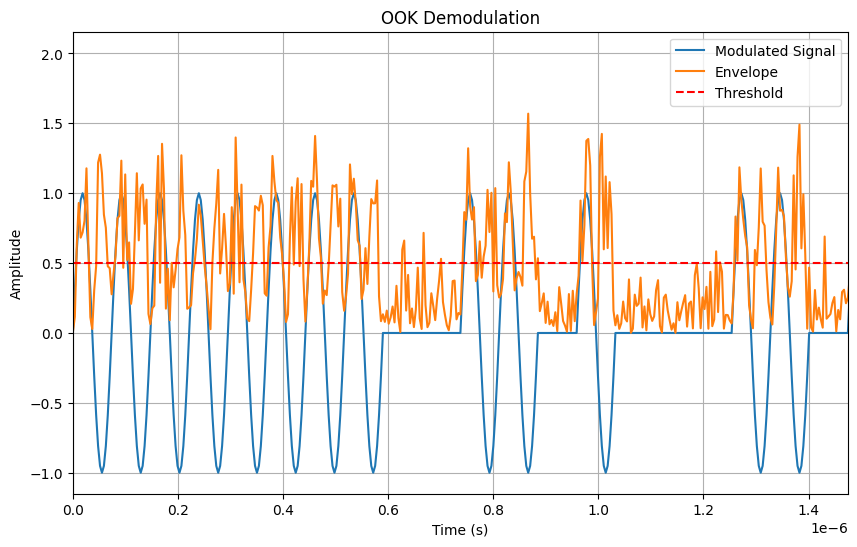

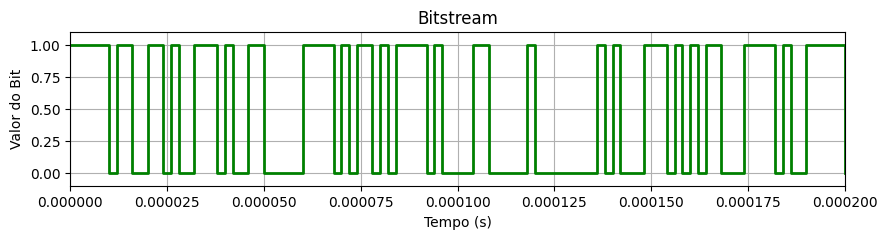

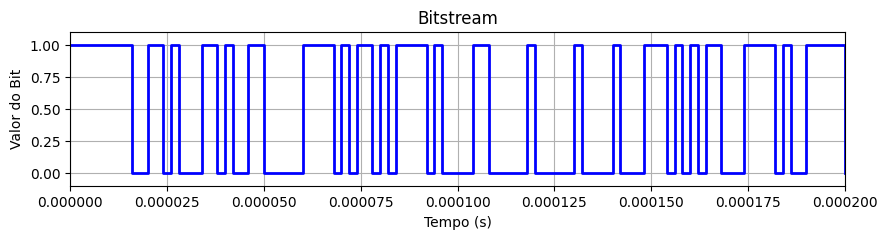

In [4]:
# Plot of Modulated Signal, Envelope and Threshold
plt.figure(figsize=(10, 6))
plt.plot(t, modulated_signal, label='Modulated Signal')
plt.plot(t, envelope, label='Envelope')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('OOK Demodulation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(0, (1/Fs)*400)
plt.grid(True)
plt.show()

# Plot of Received Bitstream (Passing through Channel)
plt.figure(figsize=(10, 2))
plt.step(np.linspace(0,duration,np.size(decoded_bitstream)), decoded_bitstream, where='post', color='g', linewidth=2)
plt.title('Bitstream')
plt.xlabel('Tempo (s)')
plt.ylabel('Valor do Bit')
plt.ylim(-0.1, 1.1)
plt.xlim(0,(1/bits_per_second)* 100)
plt.grid(True)
plt.show()

# Plot of Original BitStream 
plt.figure(figsize=(10, 2))
plt.step(np.linspace(0,duration,np.size(bitstream)), bitstream, where='post', color='b', linewidth=2)
plt.title('Bitstream')
plt.xlabel('Tempo (s)')
plt.ylabel('Valor do Bit')
plt.ylim(-0.1, 1.1)
plt.xlim(0,(1/bits_per_second)* 100)
plt.grid(True)
plt.show()

In [5]:
SNR_dB = np.arange(0,30,1) # Signal to Noise ratio in dB

# Add AWGN on modulated signal
# Calculate modulated signal power
signal_power = np.mean(modulated_signal ** 2)

# Calculate the noise power using the desired SNR
noise_power = [ signal_power / (10 ** (snr / 10)) for snr in SNR_dB ]

# Generate noise signal with same size as modulated signal and corresponding noise power. 
noise = [ np.random.normal(scale=np.sqrt(noise_pwr), size=len(modulated_signal)) for noise_pwr in noise_power ]

# Adding the noise to the modulated signal
noisy_modulated_signal = [ modulated_signal + nse for nse in noise ]



In [6]:
# Demodulation OOK (Envelope Detection)
envelope = [ np.abs(noisy_modul_signal) for noisy_modul_signal in noisy_modulated_signal ]

# Define a Threshold related to decide between 0s and 1s.
threshold = 0.5

decoded_bitstream = [ np.zeros_like(bitstream) for i in range(np.size(SNR_dB)) ]

In [7]:
for k in range(np.size(SNR_dB)):    
    for i in range(np.size(bitstream)):
        start = i * overSamplingValue 
        end = (i+1) * overSamplingValue
        eval_index = int((0.7 * end) + (0.3 * start))
        if envelope[k][eval_index] > threshold:
            decoded_bitstream[k][i] = 1

In [8]:
bit_error_rate = [ np.mean(decoded_bits != bitstream)  for decoded_bits in decoded_bitstream ]
bit_error_rate = [100*ber for ber in bit_error_rate] 

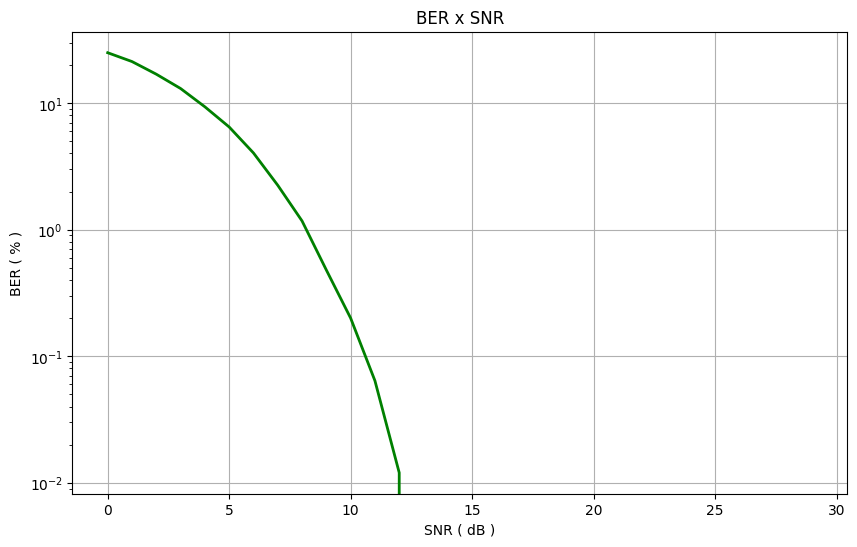

In [9]:
plt.figure(figsize=(10, 6))
plt.semilogy(SNR_dB,bit_error_rate,color='g',linewidth='2')
plt.title('BER x SNR')
plt.xlabel('SNR ( dB )')
plt.ylabel('BER ( % )')
plt.grid(True)
plt.show()